# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [15]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

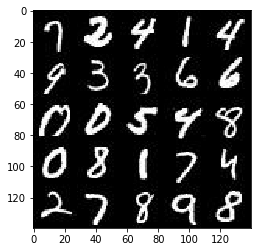

In [46]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

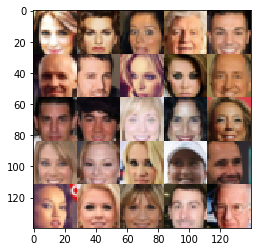

In [17]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [18]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [19]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real   = tf.placeholder(tf.float32, (None, image_width, 
                                                      image_height, 
                                                      image_channels), name='input_real')
    inputs_z      = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32,  None, name='learning_rate')
    
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [20]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        
        x1 = tf.layers.conv2d(images, 128, 5, strides=2, padding='same')
        bn1 = tf.layers.batch_normalization(x1, training=True)
        relu1 = tf.maximum(alpha * bn1, bn1)
        # 14x14x128
        
        x2 = tf.layers.conv2d(relu1, 256, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x256

        # Flatten it
        flat = tf.reshape(relu2, (-1, 7*7*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [21]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """    
    
    with tf.variable_scope('generator', reuse= not is_train):
        
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*256)
        
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x256 now
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3 now   
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [22]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [23]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [24]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [61]:
class GAN:
    def __init__(self, image_h, image_w, image_ch, z_size, learning_rate, alpha=0.2, beta1=0.5):
        tf.reset_default_graph()
    
        self.input_real, self.input_z, lr = model_inputs(image_h, image_w, image_ch, z_size)
        self.d_loss, self.g_loss          = model_loss(self.input_real, self.input_z, image_ch, alpha=alpha)
        self.d_opt, self.g_opt            = model_opt(self.d_loss, self.g_loss, learning_rate, beta1)

In [62]:
def scale(x):
    x *= 2
    return x

In [65]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    steps = 0
    print_every = 10
    show_every  = 50
    
    # extract image format
    image_h = data_shape[1]
    image_w = data_shape[2]
    image_ch = 1
    if data_image_mode == "RGB":
        image_ch = 3
        
    losses = []
    alpha = 0.2
    
    # Init the net
    net = GAN(image_h, image_w, image_ch, z_dim, learning_rate, alpha=alpha, beta1=beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                # scaling up to [-1,1] range
                batch_images = scale(batch_images)
                
                #print(batch_images[0])
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(net.d_opt, feed_dict={net.input_real: batch_images, net.input_z: batch_z})
                _ = sess.run(net.g_opt, feed_dict={net.input_z: batch_z, net.input_real: batch_images})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = net.d_loss.eval({net.input_z: batch_z, net.input_real: batch_images})
                    train_loss_g = net.g_loss.eval({net.input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 16, net.input_z, image_ch, data_image_mode)
  
        # Show final
        show_generator_output(sess, 16, net.input_z, image_ch, data_image_mode)
        
        # print the losses
        ax = pyplot.subplots()
        losses = np.array(losses)
        pyplot.plot(losses.T[0], label='Discriminator', alpha=0.5)
        pyplot.plot(losses.T[1], label='Generator', alpha=0.5)
        pyplot.title("Training Losses")
        pyplot.legend()
    
    print('done.')            

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 2.9174... Generator Loss: 15.6091
Epoch 1/2... Discriminator Loss: 3.4699... Generator Loss: 7.7843
Epoch 1/2... Discriminator Loss: 3.1023... Generator Loss: 3.6765
Epoch 1/2... Discriminator Loss: 2.3175... Generator Loss: 3.2231
Epoch 1/2... Discriminator Loss: 2.3955... Generator Loss: 2.4507


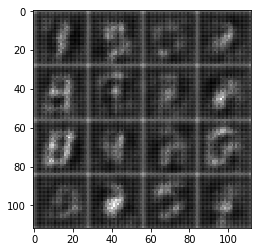

Epoch 1/2... Discriminator Loss: 2.0969... Generator Loss: 2.6241
Epoch 1/2... Discriminator Loss: 2.1195... Generator Loss: 2.6360
Epoch 1/2... Discriminator Loss: 1.9671... Generator Loss: 2.2996
Epoch 1/2... Discriminator Loss: 1.9968... Generator Loss: 2.2370
Epoch 1/2... Discriminator Loss: 1.5723... Generator Loss: 1.7256


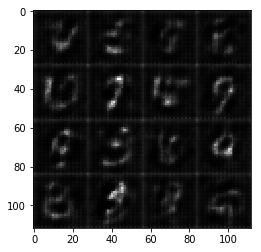

Epoch 1/2... Discriminator Loss: 1.6752... Generator Loss: 1.9274
Epoch 1/2... Discriminator Loss: 1.6731... Generator Loss: 2.4812
Epoch 1/2... Discriminator Loss: 1.5744... Generator Loss: 2.3593
Epoch 1/2... Discriminator Loss: 1.4584... Generator Loss: 2.3385
Epoch 1/2... Discriminator Loss: 1.3999... Generator Loss: 2.6251


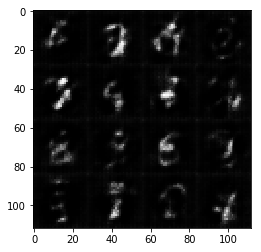

Epoch 1/2... Discriminator Loss: 1.4669... Generator Loss: 2.6311
Epoch 1/2... Discriminator Loss: 1.4414... Generator Loss: 2.4143
Epoch 1/2... Discriminator Loss: 1.3061... Generator Loss: 1.9919
Epoch 1/2... Discriminator Loss: 1.5317... Generator Loss: 2.1190
Epoch 1/2... Discriminator Loss: 1.5764... Generator Loss: 1.8545


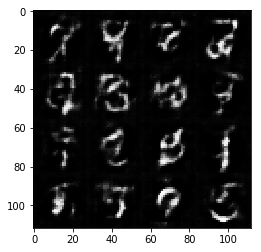

Epoch 1/2... Discriminator Loss: 1.3877... Generator Loss: 1.7810
Epoch 1/2... Discriminator Loss: 1.4973... Generator Loss: 2.2012
Epoch 1/2... Discriminator Loss: 1.4796... Generator Loss: 2.1942
Epoch 1/2... Discriminator Loss: 1.3361... Generator Loss: 1.8586
Epoch 1/2... Discriminator Loss: 1.4648... Generator Loss: 2.0965


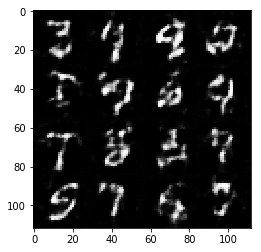

Epoch 1/2... Discriminator Loss: 1.1456... Generator Loss: 1.8852
Epoch 1/2... Discriminator Loss: 1.3549... Generator Loss: 2.0504
Epoch 1/2... Discriminator Loss: 1.3056... Generator Loss: 1.7964
Epoch 1/2... Discriminator Loss: 1.4541... Generator Loss: 2.1046
Epoch 1/2... Discriminator Loss: 1.3327... Generator Loss: 1.8739


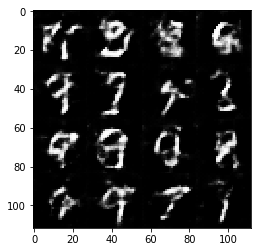

Epoch 1/2... Discriminator Loss: 1.2771... Generator Loss: 1.8233
Epoch 1/2... Discriminator Loss: 1.3740... Generator Loss: 2.0569
Epoch 1/2... Discriminator Loss: 1.2745... Generator Loss: 1.6129
Epoch 1/2... Discriminator Loss: 1.4424... Generator Loss: 1.8186
Epoch 1/2... Discriminator Loss: 1.3515... Generator Loss: 1.8861


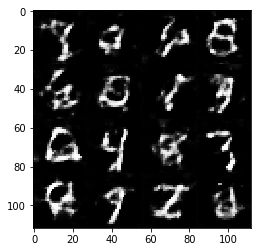

Epoch 1/2... Discriminator Loss: 1.2865... Generator Loss: 1.8110
Epoch 1/2... Discriminator Loss: 1.3802... Generator Loss: 1.6789
Epoch 1/2... Discriminator Loss: 1.3337... Generator Loss: 1.7882
Epoch 1/2... Discriminator Loss: 1.4482... Generator Loss: 2.0156
Epoch 1/2... Discriminator Loss: 1.3756... Generator Loss: 1.8826


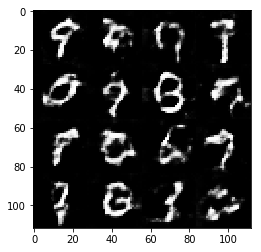

Epoch 1/2... Discriminator Loss: 1.2338... Generator Loss: 1.7812
Epoch 1/2... Discriminator Loss: 1.1562... Generator Loss: 1.8704
Epoch 1/2... Discriminator Loss: 1.3343... Generator Loss: 1.9348
Epoch 1/2... Discriminator Loss: 1.2084... Generator Loss: 1.5922
Epoch 1/2... Discriminator Loss: 1.2853... Generator Loss: 1.7903


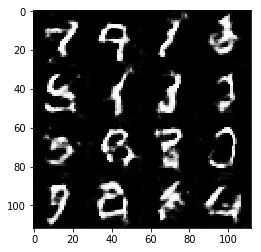

Epoch 1/2... Discriminator Loss: 1.2525... Generator Loss: 1.7644
Epoch 2/2... Discriminator Loss: 1.3161... Generator Loss: 1.6838
Epoch 2/2... Discriminator Loss: 1.1967... Generator Loss: 1.4503
Epoch 2/2... Discriminator Loss: 1.3377... Generator Loss: 1.4816
Epoch 2/2... Discriminator Loss: 1.2230... Generator Loss: 1.5257


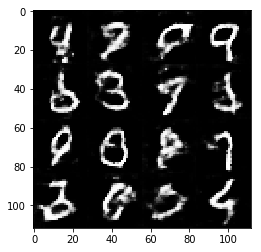

Epoch 2/2... Discriminator Loss: 1.2091... Generator Loss: 1.5554
Epoch 2/2... Discriminator Loss: 1.2907... Generator Loss: 1.6279
Epoch 2/2... Discriminator Loss: 1.2325... Generator Loss: 1.6973
Epoch 2/2... Discriminator Loss: 1.3319... Generator Loss: 1.5840
Epoch 2/2... Discriminator Loss: 1.3318... Generator Loss: 1.6482


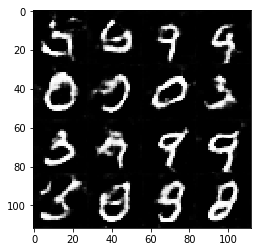

Epoch 2/2... Discriminator Loss: 1.1720... Generator Loss: 1.4584
Epoch 2/2... Discriminator Loss: 1.2104... Generator Loss: 1.1932
Epoch 2/2... Discriminator Loss: 1.2669... Generator Loss: 1.5749
Epoch 2/2... Discriminator Loss: 1.2966... Generator Loss: 1.4224
Epoch 2/2... Discriminator Loss: 1.1575... Generator Loss: 1.4604


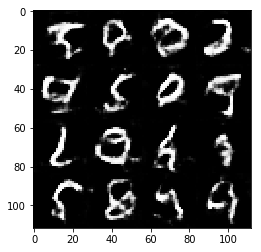

Epoch 2/2... Discriminator Loss: 1.1850... Generator Loss: 1.4143
Epoch 2/2... Discriminator Loss: 1.3412... Generator Loss: 1.4309
Epoch 2/2... Discriminator Loss: 1.4054... Generator Loss: 1.8307
Epoch 2/2... Discriminator Loss: 1.2562... Generator Loss: 1.3837
Epoch 2/2... Discriminator Loss: 1.2524... Generator Loss: 1.4862


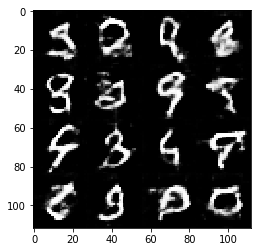

Epoch 2/2... Discriminator Loss: 1.2387... Generator Loss: 1.4744
Epoch 2/2... Discriminator Loss: 1.2971... Generator Loss: 1.3355
Epoch 2/2... Discriminator Loss: 1.6509... Generator Loss: 1.8847
Epoch 2/2... Discriminator Loss: 1.2533... Generator Loss: 1.3844
Epoch 2/2... Discriminator Loss: 1.2223... Generator Loss: 1.3976


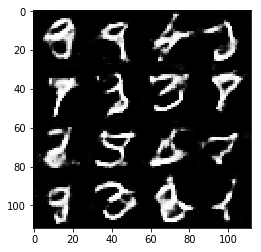

Epoch 2/2... Discriminator Loss: 1.2732... Generator Loss: 1.5354
Epoch 2/2... Discriminator Loss: 1.2342... Generator Loss: 1.4104
Epoch 2/2... Discriminator Loss: 1.0848... Generator Loss: 0.8939
Epoch 2/2... Discriminator Loss: 1.7170... Generator Loss: 0.2746
Epoch 2/2... Discriminator Loss: 1.4890... Generator Loss: 0.4080


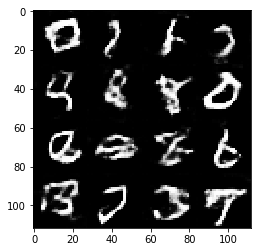

Epoch 2/2... Discriminator Loss: 1.4572... Generator Loss: 0.3721
Epoch 2/2... Discriminator Loss: 1.5037... Generator Loss: 0.3422
Epoch 2/2... Discriminator Loss: 1.4033... Generator Loss: 0.3908
Epoch 2/2... Discriminator Loss: 1.5219... Generator Loss: 0.3483
Epoch 2/2... Discriminator Loss: 1.4062... Generator Loss: 0.3819


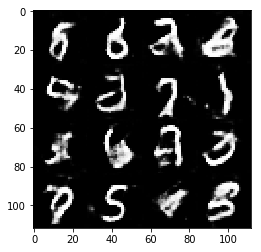

Epoch 2/2... Discriminator Loss: 1.2803... Generator Loss: 0.4672
Epoch 2/2... Discriminator Loss: 1.2276... Generator Loss: 0.4906
Epoch 2/2... Discriminator Loss: 1.5133... Generator Loss: 0.3411
Epoch 2/2... Discriminator Loss: 1.7013... Generator Loss: 0.2781
Epoch 2/2... Discriminator Loss: 1.2173... Generator Loss: 0.5522


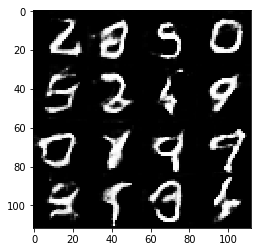

Epoch 2/2... Discriminator Loss: 1.4487... Generator Loss: 0.3593
Epoch 2/2... Discriminator Loss: 1.4068... Generator Loss: 0.3685
Epoch 2/2... Discriminator Loss: 1.2201... Generator Loss: 0.4966
Epoch 2/2... Discriminator Loss: 1.1833... Generator Loss: 0.5435
Epoch 2/2... Discriminator Loss: 1.9522... Generator Loss: 0.2157


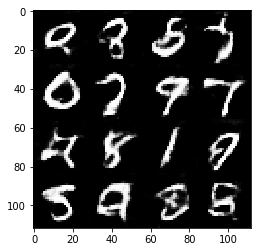

Epoch 2/2... Discriminator Loss: 1.2059... Generator Loss: 0.5620
Epoch 2/2... Discriminator Loss: 1.1089... Generator Loss: 0.6272
Epoch 2/2... Discriminator Loss: 1.3796... Generator Loss: 0.3894


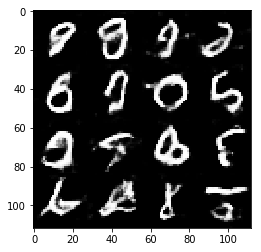

done.


IndexError: list index out of range

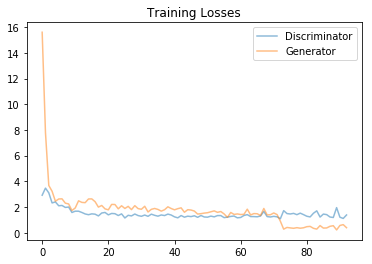

In [69]:
batch_size = 128
z_dim = 64
learning_rate = 0.001
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.5395... Generator Loss: 1.5535
Epoch 1/1... Discriminator Loss: 0.4333... Generator Loss: 1.6167
Epoch 1/1... Discriminator Loss: 0.2018... Generator Loss: 2.5551
Epoch 1/1... Discriminator Loss: 0.1877... Generator Loss: 3.3656
Epoch 1/1... Discriminator Loss: 0.4451... Generator Loss: 1.3230


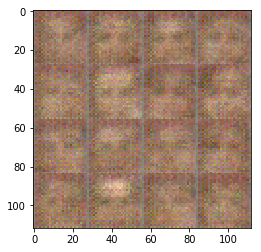

Epoch 1/1... Discriminator Loss: 1.1872... Generator Loss: 3.7993
Epoch 1/1... Discriminator Loss: 1.2169... Generator Loss: 0.5395
Epoch 1/1... Discriminator Loss: 0.7856... Generator Loss: 0.9097
Epoch 1/1... Discriminator Loss: 0.6602... Generator Loss: 1.1456
Epoch 1/1... Discriminator Loss: 0.4803... Generator Loss: 1.5586


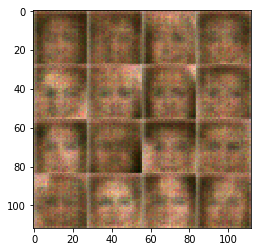

Epoch 1/1... Discriminator Loss: 0.4699... Generator Loss: 2.2565
Epoch 1/1... Discriminator Loss: 0.4531... Generator Loss: 1.8336
Epoch 1/1... Discriminator Loss: 1.0170... Generator Loss: 3.5688
Epoch 1/1... Discriminator Loss: 0.8185... Generator Loss: 0.9169
Epoch 1/1... Discriminator Loss: 0.7933... Generator Loss: 1.6201


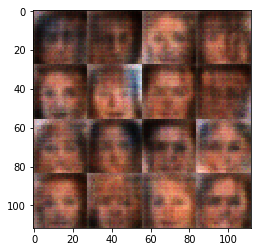

Epoch 1/1... Discriminator Loss: 0.6230... Generator Loss: 1.7007
Epoch 1/1... Discriminator Loss: 1.3504... Generator Loss: 2.9411
Epoch 1/1... Discriminator Loss: 1.0198... Generator Loss: 0.6519
Epoch 1/1... Discriminator Loss: 0.8310... Generator Loss: 2.0753
Epoch 1/1... Discriminator Loss: 0.7898... Generator Loss: 0.8854


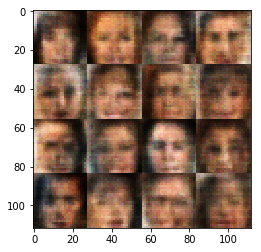

Epoch 1/1... Discriminator Loss: 0.5394... Generator Loss: 1.3492
Epoch 1/1... Discriminator Loss: 1.0838... Generator Loss: 2.7253
Epoch 1/1... Discriminator Loss: 0.7404... Generator Loss: 1.0088
Epoch 1/1... Discriminator Loss: 0.7013... Generator Loss: 1.1873
Epoch 1/1... Discriminator Loss: 0.4467... Generator Loss: 1.9797


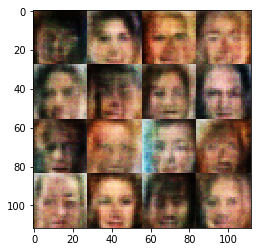

Epoch 1/1... Discriminator Loss: 0.6049... Generator Loss: 2.8228
Epoch 1/1... Discriminator Loss: 0.4268... Generator Loss: 1.9815
Epoch 1/1... Discriminator Loss: 0.6954... Generator Loss: 0.9476
Epoch 1/1... Discriminator Loss: 1.1992... Generator Loss: 1.8340
Epoch 1/1... Discriminator Loss: 0.7825... Generator Loss: 1.5800


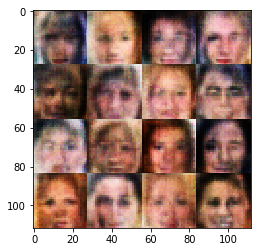

Epoch 1/1... Discriminator Loss: 0.6757... Generator Loss: 1.9815
Epoch 1/1... Discriminator Loss: 0.6559... Generator Loss: 1.5288
Epoch 1/1... Discriminator Loss: 0.6857... Generator Loss: 0.9819
Epoch 1/1... Discriminator Loss: 0.4829... Generator Loss: 1.3879
Epoch 1/1... Discriminator Loss: 0.8308... Generator Loss: 0.7657


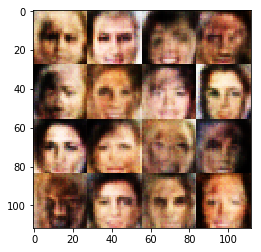

Epoch 1/1... Discriminator Loss: 1.9450... Generator Loss: 0.2191
Epoch 1/1... Discriminator Loss: 1.1946... Generator Loss: 0.5995
Epoch 1/1... Discriminator Loss: 0.6642... Generator Loss: 1.1015
Epoch 1/1... Discriminator Loss: 0.7041... Generator Loss: 1.0069
Epoch 1/1... Discriminator Loss: 0.8153... Generator Loss: 0.8109


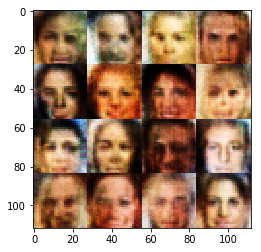

Epoch 1/1... Discriminator Loss: 1.9956... Generator Loss: 0.2045
Epoch 1/1... Discriminator Loss: 0.3744... Generator Loss: 2.7501
Epoch 1/1... Discriminator Loss: 1.8094... Generator Loss: 0.2531
Epoch 1/1... Discriminator Loss: 0.9163... Generator Loss: 0.6976
Epoch 1/1... Discriminator Loss: 0.7723... Generator Loss: 1.5577


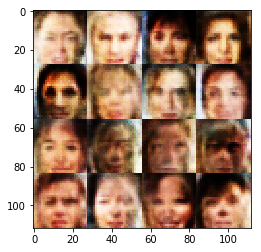

Epoch 1/1... Discriminator Loss: 0.4778... Generator Loss: 1.6108
Epoch 1/1... Discriminator Loss: 1.1155... Generator Loss: 3.7086
Epoch 1/1... Discriminator Loss: 0.5285... Generator Loss: 3.1340
Epoch 1/1... Discriminator Loss: 1.6765... Generator Loss: 0.2908
Epoch 1/1... Discriminator Loss: 1.6283... Generator Loss: 0.2848


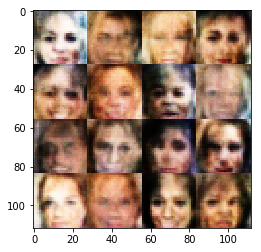

Epoch 1/1... Discriminator Loss: 0.8356... Generator Loss: 1.7353
Epoch 1/1... Discriminator Loss: 0.6474... Generator Loss: 3.9205
Epoch 1/1... Discriminator Loss: 1.0723... Generator Loss: 0.5992
Epoch 1/1... Discriminator Loss: 0.8904... Generator Loss: 3.4994
Epoch 1/1... Discriminator Loss: 1.3717... Generator Loss: 1.6580


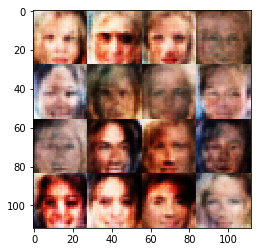

Epoch 1/1... Discriminator Loss: 0.4762... Generator Loss: 3.5706
Epoch 1/1... Discriminator Loss: 1.4497... Generator Loss: 0.4857
Epoch 1/1... Discriminator Loss: 0.5907... Generator Loss: 3.5161
Epoch 1/1... Discriminator Loss: 0.2192... Generator Loss: 3.6114
Epoch 1/1... Discriminator Loss: 0.8730... Generator Loss: 3.1844


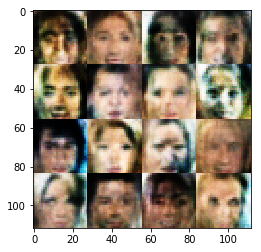

Epoch 1/1... Discriminator Loss: 0.1798... Generator Loss: 2.6641
Epoch 1/1... Discriminator Loss: 0.9259... Generator Loss: 0.6789
Epoch 1/1... Discriminator Loss: 0.2983... Generator Loss: 2.9285
Epoch 1/1... Discriminator Loss: 0.9189... Generator Loss: 6.4094
Epoch 1/1... Discriminator Loss: 0.1905... Generator Loss: 2.8065


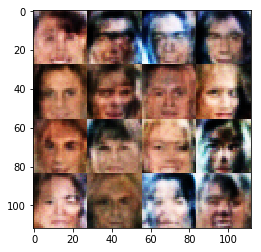

Epoch 1/1... Discriminator Loss: 0.9173... Generator Loss: 0.6233
Epoch 1/1... Discriminator Loss: 0.3327... Generator Loss: 1.6568
Epoch 1/1... Discriminator Loss: 0.3162... Generator Loss: 4.2845
Epoch 1/1... Discriminator Loss: 0.4808... Generator Loss: 1.3696
Epoch 1/1... Discriminator Loss: 0.5904... Generator Loss: 0.9977


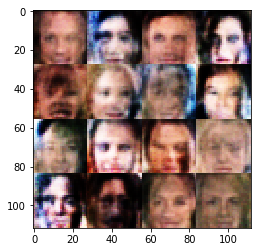

Epoch 1/1... Discriminator Loss: 1.5735... Generator Loss: 0.2808
Epoch 1/1... Discriminator Loss: 0.1145... Generator Loss: 3.6788
Epoch 1/1... Discriminator Loss: 0.6203... Generator Loss: 1.5087
Epoch 1/1... Discriminator Loss: 0.2418... Generator Loss: 2.5701
Epoch 1/1... Discriminator Loss: 0.6442... Generator Loss: 7.6303


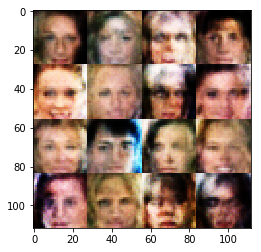

Epoch 1/1... Discriminator Loss: 0.3918... Generator Loss: 8.8790
Epoch 1/1... Discriminator Loss: 0.7034... Generator Loss: 1.0677
Epoch 1/1... Discriminator Loss: 0.0837... Generator Loss: 5.6468
Epoch 1/1... Discriminator Loss: 0.5015... Generator Loss: 1.2091
Epoch 1/1... Discriminator Loss: 0.4344... Generator Loss: 1.2902


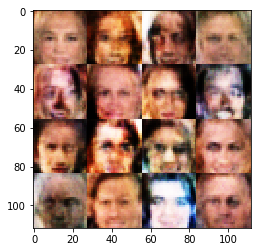

Epoch 1/1... Discriminator Loss: 0.1311... Generator Loss: 2.5727
Epoch 1/1... Discriminator Loss: 0.3181... Generator Loss: 2.0161
Epoch 1/1... Discriminator Loss: 1.3844... Generator Loss: 0.3459
Epoch 1/1... Discriminator Loss: 0.4620... Generator Loss: 1.2291
Epoch 1/1... Discriminator Loss: 0.1145... Generator Loss: 4.6171


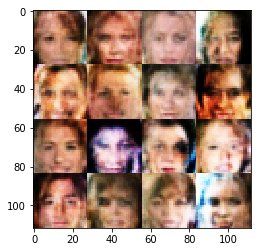

Epoch 1/1... Discriminator Loss: 0.1645... Generator Loss: 3.0466
Epoch 1/1... Discriminator Loss: 0.0729... Generator Loss: 4.5500
Epoch 1/1... Discriminator Loss: 1.0910... Generator Loss: 0.5928
Epoch 1/1... Discriminator Loss: 0.5263... Generator Loss: 3.4140
Epoch 1/1... Discriminator Loss: 1.2080... Generator Loss: 0.5133


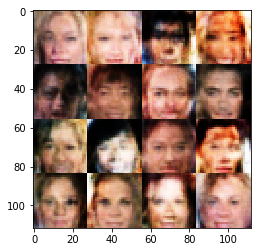

Epoch 1/1... Discriminator Loss: 0.3405... Generator Loss: 2.2771
Epoch 1/1... Discriminator Loss: 0.3172... Generator Loss: 1.6385
Epoch 1/1... Discriminator Loss: 0.1243... Generator Loss: 3.9786
Epoch 1/1... Discriminator Loss: 0.2335... Generator Loss: 6.8245
Epoch 1/1... Discriminator Loss: 0.0963... Generator Loss: 4.6677


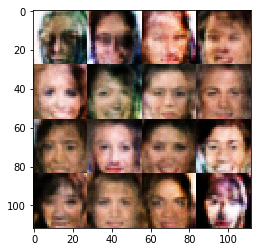

Epoch 1/1... Discriminator Loss: 0.3091... Generator Loss: 1.7270
Epoch 1/1... Discriminator Loss: 0.1967... Generator Loss: 5.7886
Epoch 1/1... Discriminator Loss: 0.4499... Generator Loss: 1.2770
Epoch 1/1... Discriminator Loss: 0.3946... Generator Loss: 1.7634
Epoch 1/1... Discriminator Loss: 0.1269... Generator Loss: 5.3208


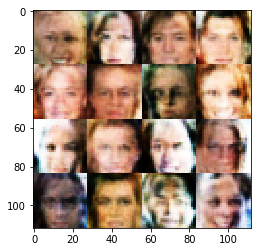

Epoch 1/1... Discriminator Loss: 1.0496... Generator Loss: 0.5485
Epoch 1/1... Discriminator Loss: 0.2690... Generator Loss: 1.8572
Epoch 1/1... Discriminator Loss: 0.3984... Generator Loss: 4.8310
Epoch 1/1... Discriminator Loss: 0.5602... Generator Loss: 5.3218
Epoch 1/1... Discriminator Loss: 0.1502... Generator Loss: 4.6144


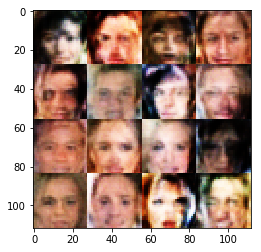

Epoch 1/1... Discriminator Loss: 0.3976... Generator Loss: 1.4418
Epoch 1/1... Discriminator Loss: 0.3073... Generator Loss: 1.9846
Epoch 1/1... Discriminator Loss: 0.9099... Generator Loss: 0.6935
Epoch 1/1... Discriminator Loss: 0.4361... Generator Loss: 1.4444
Epoch 1/1... Discriminator Loss: 0.4336... Generator Loss: 1.5646


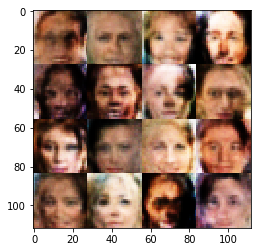

Epoch 1/1... Discriminator Loss: 0.3545... Generator Loss: 1.7444
Epoch 1/1... Discriminator Loss: 0.1870... Generator Loss: 5.4945
Epoch 1/1... Discriminator Loss: 0.1410... Generator Loss: 2.7749
Epoch 1/1... Discriminator Loss: 0.0589... Generator Loss: 5.3925
Epoch 1/1... Discriminator Loss: 0.0991... Generator Loss: 3.5076


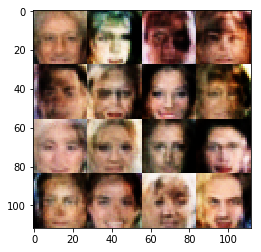

Epoch 1/1... Discriminator Loss: 1.8105... Generator Loss: 0.2306
Epoch 1/1... Discriminator Loss: 1.0635... Generator Loss: 0.5927
Epoch 1/1... Discriminator Loss: 0.2121... Generator Loss: 2.3823
Epoch 1/1... Discriminator Loss: 0.2770... Generator Loss: 2.1519
Epoch 1/1... Discriminator Loss: 0.2064... Generator Loss: 3.2988


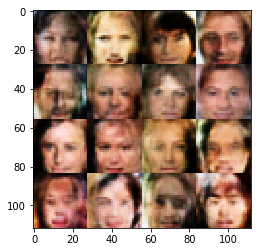

Epoch 1/1... Discriminator Loss: 0.3535... Generator Loss: 5.6228
Epoch 1/1... Discriminator Loss: 0.6443... Generator Loss: 0.9530
Epoch 1/1... Discriminator Loss: 0.1196... Generator Loss: 5.2513
Epoch 1/1... Discriminator Loss: 0.6493... Generator Loss: 1.2375
Epoch 1/1... Discriminator Loss: 1.3754... Generator Loss: 0.3611


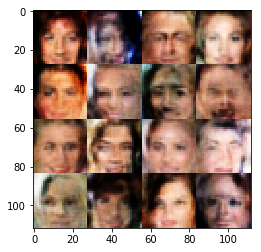

Epoch 1/1... Discriminator Loss: 0.2788... Generator Loss: 2.1747
Epoch 1/1... Discriminator Loss: 0.7802... Generator Loss: 0.7957
Epoch 1/1... Discriminator Loss: 0.0969... Generator Loss: 3.3208
Epoch 1/1... Discriminator Loss: 1.4437... Generator Loss: 5.1777
Epoch 1/1... Discriminator Loss: 1.6371... Generator Loss: 3.5082


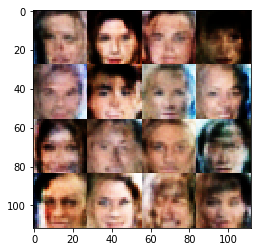

Epoch 1/1... Discriminator Loss: 1.4932... Generator Loss: 5.6786
Epoch 1/1... Discriminator Loss: 0.1979... Generator Loss: 3.3464
Epoch 1/1... Discriminator Loss: 1.2159... Generator Loss: 10.3904
Epoch 1/1... Discriminator Loss: 0.6595... Generator Loss: 0.8818
Epoch 1/1... Discriminator Loss: 0.2496... Generator Loss: 7.0057


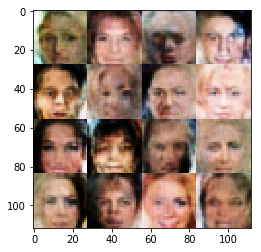

Epoch 1/1... Discriminator Loss: 0.1729... Generator Loss: 3.2433
Epoch 1/1... Discriminator Loss: 0.3826... Generator Loss: 5.9313
Epoch 1/1... Discriminator Loss: 0.8249... Generator Loss: 0.7474
Epoch 1/1... Discriminator Loss: 0.1607... Generator Loss: 2.5610
Epoch 1/1... Discriminator Loss: 0.3767... Generator Loss: 1.4911


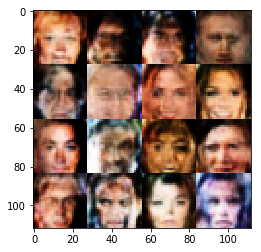

Epoch 1/1... Discriminator Loss: 0.3697... Generator Loss: 4.7465
Epoch 1/1... Discriminator Loss: 0.1561... Generator Loss: 5.1343
Epoch 1/1... Discriminator Loss: 0.0895... Generator Loss: 3.7465
Epoch 1/1... Discriminator Loss: 0.3291... Generator Loss: 1.5213
Epoch 1/1... Discriminator Loss: 0.1483... Generator Loss: 6.5102


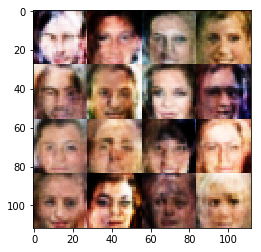

Epoch 1/1... Discriminator Loss: 0.2929... Generator Loss: 1.8809
Epoch 1/1... Discriminator Loss: 0.1525... Generator Loss: 2.6689
Epoch 1/1... Discriminator Loss: 0.1779... Generator Loss: 2.8772
Epoch 1/1... Discriminator Loss: 0.3813... Generator Loss: 7.2739
Epoch 1/1... Discriminator Loss: 0.0865... Generator Loss: 4.6049


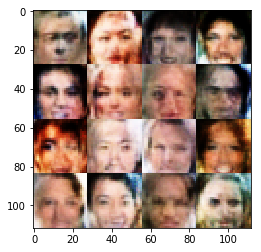

Epoch 1/1... Discriminator Loss: 0.3023... Generator Loss: 1.6765
Epoch 1/1... Discriminator Loss: 0.1122... Generator Loss: 4.1301
Epoch 1/1... Discriminator Loss: 0.1069... Generator Loss: 8.3564
Epoch 1/1... Discriminator Loss: 0.0694... Generator Loss: 3.5772
Epoch 1/1... Discriminator Loss: 1.8801... Generator Loss: 4.2188


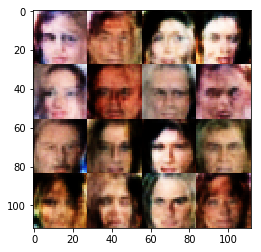

Epoch 1/1... Discriminator Loss: 0.8824... Generator Loss: 1.6833
Epoch 1/1... Discriminator Loss: 0.5142... Generator Loss: 6.0774
Epoch 1/1... Discriminator Loss: 0.2935... Generator Loss: 4.7518


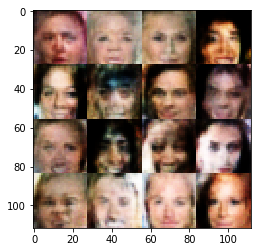

done.


IndexError: list index out of range

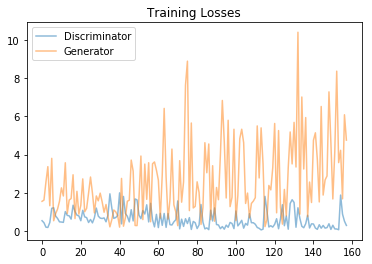

In [85]:

#Testing parameters from the attached paper
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

Epoch 1/1... Discriminator Loss: 3.1342... Generator Loss: 0.0658
Epoch 1/1... Discriminator Loss: 0.2026... Generator Loss: 2.6649
Epoch 1/1... Discriminator Loss: 2.2903... Generator Loss: 6.5728
Epoch 1/1... Discriminator Loss: 2.2913... Generator Loss: 5.1614
Epoch 1/1... Discriminator Loss: 1.7426... Generator Loss: 5.0356


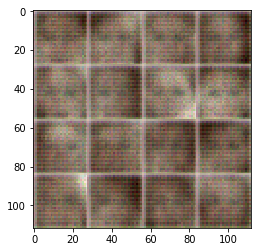

Epoch 1/1... Discriminator Loss: 1.9944... Generator Loss: 3.4256
Epoch 1/1... Discriminator Loss: 2.1079... Generator Loss: 4.5695
Epoch 1/1... Discriminator Loss: 1.1954... Generator Loss: 4.8392
Epoch 1/1... Discriminator Loss: 1.3104... Generator Loss: 2.9207
Epoch 1/1... Discriminator Loss: 1.6512... Generator Loss: 2.3075


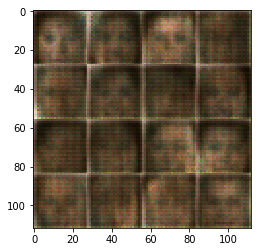

Epoch 1/1... Discriminator Loss: 1.7699... Generator Loss: 2.6361
Epoch 1/1... Discriminator Loss: 1.4483... Generator Loss: 2.6693
Epoch 1/1... Discriminator Loss: 1.4926... Generator Loss: 2.8558
Epoch 1/1... Discriminator Loss: 0.9570... Generator Loss: 3.8180
Epoch 1/1... Discriminator Loss: 1.4124... Generator Loss: 2.1236


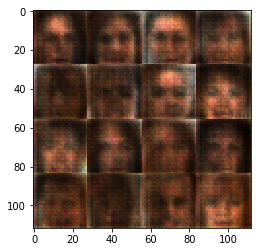

Epoch 1/1... Discriminator Loss: 1.5533... Generator Loss: 2.0879
Epoch 1/1... Discriminator Loss: 1.2756... Generator Loss: 2.7843
Epoch 1/1... Discriminator Loss: 1.2948... Generator Loss: 2.6916
Epoch 1/1... Discriminator Loss: 1.1370... Generator Loss: 2.4457
Epoch 1/1... Discriminator Loss: 1.9458... Generator Loss: 2.6310


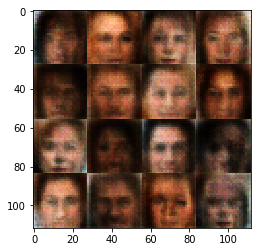

Epoch 1/1... Discriminator Loss: 1.3298... Generator Loss: 2.6123
Epoch 1/1... Discriminator Loss: 1.0188... Generator Loss: 2.9243
Epoch 1/1... Discriminator Loss: 0.7249... Generator Loss: 3.8280
Epoch 1/1... Discriminator Loss: 0.9954... Generator Loss: 3.6413
Epoch 1/1... Discriminator Loss: 0.9753... Generator Loss: 3.5906


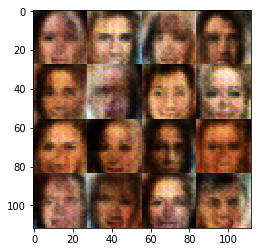

Epoch 1/1... Discriminator Loss: 1.2525... Generator Loss: 2.3637
Epoch 1/1... Discriminator Loss: 0.8531... Generator Loss: 2.9240
Epoch 1/1... Discriminator Loss: 0.9724... Generator Loss: 2.6638
Epoch 1/1... Discriminator Loss: 1.4653... Generator Loss: 3.3796
Epoch 1/1... Discriminator Loss: 1.6074... Generator Loss: 2.1665


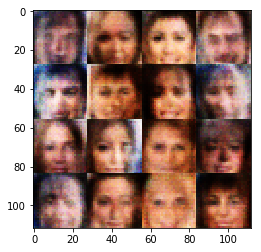

Epoch 1/1... Discriminator Loss: 0.9566... Generator Loss: 4.5791
Epoch 1/1... Discriminator Loss: 1.3417... Generator Loss: 2.3149
Epoch 1/1... Discriminator Loss: 1.1723... Generator Loss: 2.4571
Epoch 1/1... Discriminator Loss: 1.1830... Generator Loss: 0.4731
Epoch 1/1... Discriminator Loss: 1.1214... Generator Loss: 5.4234


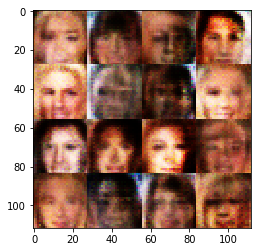

Epoch 1/1... Discriminator Loss: 1.9987... Generator Loss: 0.1805
Epoch 1/1... Discriminator Loss: 0.8124... Generator Loss: 0.7847
Epoch 1/1... Discriminator Loss: 1.1299... Generator Loss: 0.4941
Epoch 1/1... Discriminator Loss: 1.8525... Generator Loss: 0.2102
Epoch 1/1... Discriminator Loss: 0.3506... Generator Loss: 3.0826


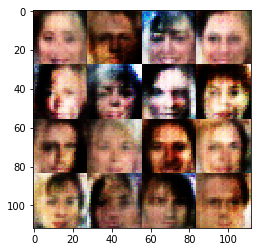

Epoch 1/1... Discriminator Loss: 0.5234... Generator Loss: 4.3480
Epoch 1/1... Discriminator Loss: 0.9008... Generator Loss: 0.6646
Epoch 1/1... Discriminator Loss: 1.1116... Generator Loss: 0.4910
Epoch 1/1... Discriminator Loss: 0.1512... Generator Loss: 3.3199
Epoch 1/1... Discriminator Loss: 0.2792... Generator Loss: 1.9253


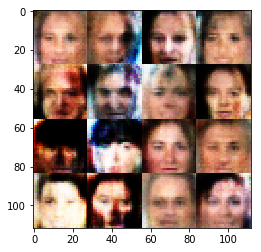

Epoch 1/1... Discriminator Loss: 1.9708... Generator Loss: 5.0554
Epoch 1/1... Discriminator Loss: 1.7293... Generator Loss: 2.5923
Epoch 1/1... Discriminator Loss: 0.6968... Generator Loss: 1.0156
Epoch 1/1... Discriminator Loss: 0.1464... Generator Loss: 3.1652
Epoch 1/1... Discriminator Loss: 0.4318... Generator Loss: 1.2137


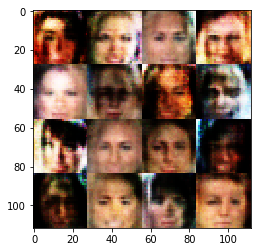

Epoch 1/1... Discriminator Loss: 0.2629... Generator Loss: 1.9102
Epoch 1/1... Discriminator Loss: 0.6513... Generator Loss: 6.4563
Epoch 1/1... Discriminator Loss: 0.0964... Generator Loss: 4.1789
Epoch 1/1... Discriminator Loss: 0.5220... Generator Loss: 1.1014
Epoch 1/1... Discriminator Loss: 2.3761... Generator Loss: 0.1321


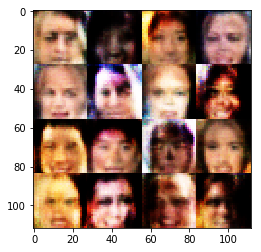

Epoch 1/1... Discriminator Loss: 1.9918... Generator Loss: 0.1967
Epoch 1/1... Discriminator Loss: 1.2849... Generator Loss: 0.5100
Epoch 1/1... Discriminator Loss: 1.2689... Generator Loss: 0.4653
Epoch 1/1... Discriminator Loss: 1.8365... Generator Loss: 0.2066
Epoch 1/1... Discriminator Loss: 1.3193... Generator Loss: 0.3813


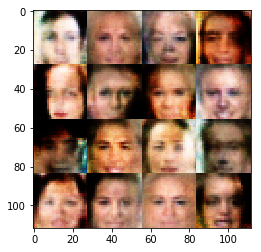

Epoch 1/1... Discriminator Loss: 0.7325... Generator Loss: 0.8496
Epoch 1/1... Discriminator Loss: 1.4866... Generator Loss: 0.3209
Epoch 1/1... Discriminator Loss: 1.4605... Generator Loss: 0.3216
Epoch 1/1... Discriminator Loss: 0.3609... Generator Loss: 3.6813
Epoch 1/1... Discriminator Loss: 0.2629... Generator Loss: 2.3170


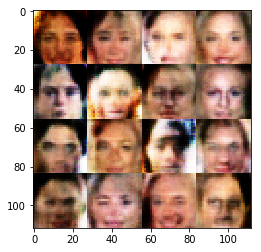

Epoch 1/1... Discriminator Loss: 0.7821... Generator Loss: 1.1624
Epoch 1/1... Discriminator Loss: 0.5572... Generator Loss: 1.1657
Epoch 1/1... Discriminator Loss: 0.5815... Generator Loss: 1.0311
Epoch 1/1... Discriminator Loss: 0.1427... Generator Loss: 3.2593
Epoch 1/1... Discriminator Loss: 2.1129... Generator Loss: 0.1943


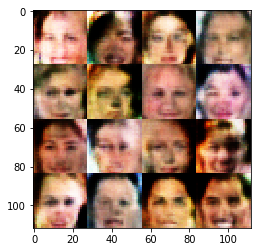

Epoch 1/1... Discriminator Loss: 1.3453... Generator Loss: 0.3867
Epoch 1/1... Discriminator Loss: 1.7313... Generator Loss: 0.2470
Epoch 1/1... Discriminator Loss: 1.4161... Generator Loss: 0.3536
Epoch 1/1... Discriminator Loss: 1.0275... Generator Loss: 0.5363
Epoch 1/1... Discriminator Loss: 0.6134... Generator Loss: 1.0177


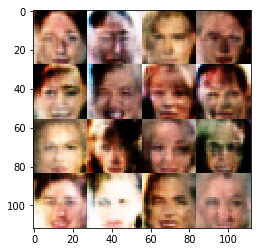

Epoch 1/1... Discriminator Loss: 1.8707... Generator Loss: 0.2045
Epoch 1/1... Discriminator Loss: 1.4191... Generator Loss: 0.3460
Epoch 1/1... Discriminator Loss: 1.2461... Generator Loss: 0.4062
Epoch 1/1... Discriminator Loss: 1.9531... Generator Loss: 0.1825
Epoch 1/1... Discriminator Loss: 0.7517... Generator Loss: 0.7856


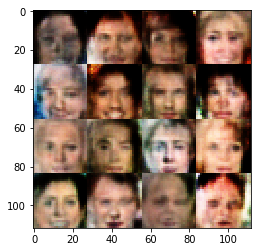

Epoch 1/1... Discriminator Loss: 1.5493... Generator Loss: 0.2938
Epoch 1/1... Discriminator Loss: 1.1703... Generator Loss: 0.4535
Epoch 1/1... Discriminator Loss: 0.6399... Generator Loss: 4.2142
Epoch 1/1... Discriminator Loss: 1.0376... Generator Loss: 3.2352
Epoch 1/1... Discriminator Loss: 0.3030... Generator Loss: 2.8051


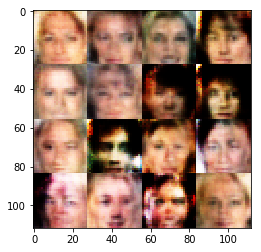

Epoch 1/1... Discriminator Loss: 0.1795... Generator Loss: 2.6386
Epoch 1/1... Discriminator Loss: 0.3318... Generator Loss: 1.6985
Epoch 1/1... Discriminator Loss: 1.8819... Generator Loss: 2.2386
Epoch 1/1... Discriminator Loss: 1.1034... Generator Loss: 3.5371
Epoch 1/1... Discriminator Loss: 0.9875... Generator Loss: 4.8024


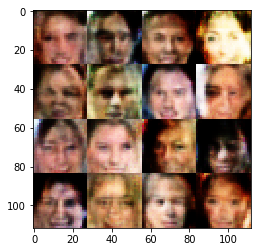

Epoch 1/1... Discriminator Loss: 0.9818... Generator Loss: 5.1697
Epoch 1/1... Discriminator Loss: 0.8402... Generator Loss: 3.8754
Epoch 1/1... Discriminator Loss: 1.8439... Generator Loss: 1.8928
Epoch 1/1... Discriminator Loss: 1.4072... Generator Loss: 5.5624
Epoch 1/1... Discriminator Loss: 2.2837... Generator Loss: 0.1354


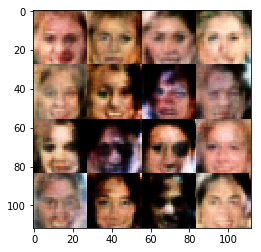

Epoch 1/1... Discriminator Loss: 1.4557... Generator Loss: 0.3658
Epoch 1/1... Discriminator Loss: 1.6423... Generator Loss: 0.2716
Epoch 1/1... Discriminator Loss: 1.3454... Generator Loss: 0.3824
Epoch 1/1... Discriminator Loss: 1.5563... Generator Loss: 0.2978
Epoch 1/1... Discriminator Loss: 1.3176... Generator Loss: 0.3847


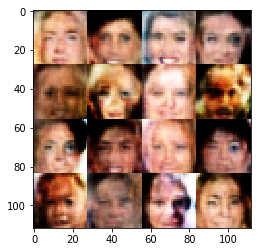

Epoch 1/1... Discriminator Loss: 0.5748... Generator Loss: 1.0283
Epoch 1/1... Discriminator Loss: 2.1276... Generator Loss: 1.3226
Epoch 1/1... Discriminator Loss: 1.0417... Generator Loss: 2.5974
Epoch 1/1... Discriminator Loss: 0.7899... Generator Loss: 2.5577
Epoch 1/1... Discriminator Loss: 1.0652... Generator Loss: 3.6003


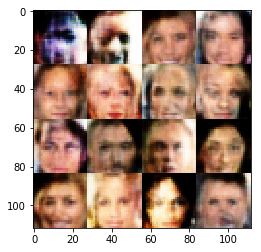

Epoch 1/1... Discriminator Loss: 0.9500... Generator Loss: 2.0641
Epoch 1/1... Discriminator Loss: 0.8492... Generator Loss: 1.7561
Epoch 1/1... Discriminator Loss: 0.9309... Generator Loss: 2.9705
Epoch 1/1... Discriminator Loss: 0.9335... Generator Loss: 4.0265
Epoch 1/1... Discriminator Loss: 1.1525... Generator Loss: 2.9431


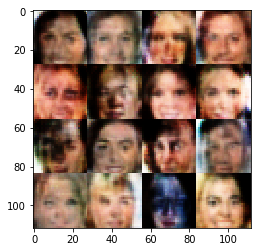

Epoch 1/1... Discriminator Loss: 0.5470... Generator Loss: 2.2465
Epoch 1/1... Discriminator Loss: 0.5015... Generator Loss: 2.9606
Epoch 1/1... Discriminator Loss: 0.6721... Generator Loss: 0.9894
Epoch 1/1... Discriminator Loss: 1.3167... Generator Loss: 3.1862
Epoch 1/1... Discriminator Loss: 1.3958... Generator Loss: 2.7693


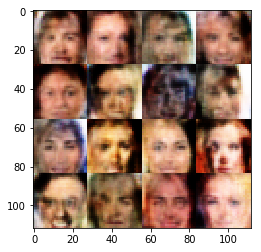

Epoch 1/1... Discriminator Loss: 0.5105... Generator Loss: 3.0844
Epoch 1/1... Discriminator Loss: 2.4157... Generator Loss: 2.5631
Epoch 1/1... Discriminator Loss: 1.1689... Generator Loss: 3.5016
Epoch 1/1... Discriminator Loss: 0.8421... Generator Loss: 1.9229
Epoch 1/1... Discriminator Loss: 1.2957... Generator Loss: 1.6953


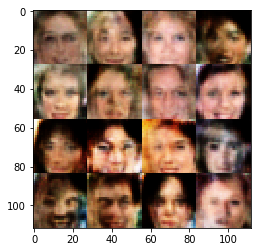

Epoch 1/1... Discriminator Loss: 0.9797... Generator Loss: 3.4374
Epoch 1/1... Discriminator Loss: 0.5842... Generator Loss: 2.3274
Epoch 1/1... Discriminator Loss: 1.6033... Generator Loss: 2.0507
Epoch 1/1... Discriminator Loss: 1.0313... Generator Loss: 3.3826
Epoch 1/1... Discriminator Loss: 0.7057... Generator Loss: 2.8766


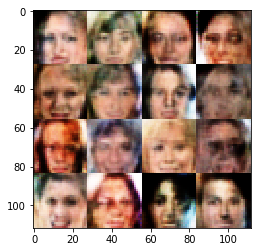

Epoch 1/1... Discriminator Loss: 0.6203... Generator Loss: 3.2162
Epoch 1/1... Discriminator Loss: 0.8238... Generator Loss: 4.2885
Epoch 1/1... Discriminator Loss: 1.3761... Generator Loss: 2.5701
Epoch 1/1... Discriminator Loss: 0.7427... Generator Loss: 2.7351
Epoch 1/1... Discriminator Loss: 0.3903... Generator Loss: 2.1392


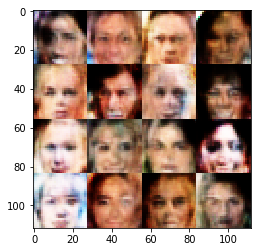

Epoch 1/1... Discriminator Loss: 0.5593... Generator Loss: 4.3504
Epoch 1/1... Discriminator Loss: 0.6966... Generator Loss: 2.5091
Epoch 1/1... Discriminator Loss: 0.6135... Generator Loss: 3.8781
Epoch 1/1... Discriminator Loss: 1.2162... Generator Loss: 1.7078
Epoch 1/1... Discriminator Loss: 0.6843... Generator Loss: 3.1866


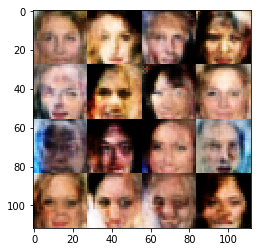

Epoch 1/1... Discriminator Loss: 0.5352... Generator Loss: 2.4868
Epoch 1/1... Discriminator Loss: 0.4390... Generator Loss: 2.8003
Epoch 1/1... Discriminator Loss: 1.5823... Generator Loss: 1.7777
Epoch 1/1... Discriminator Loss: 0.7770... Generator Loss: 2.7954
Epoch 1/1... Discriminator Loss: 0.3920... Generator Loss: 2.1773


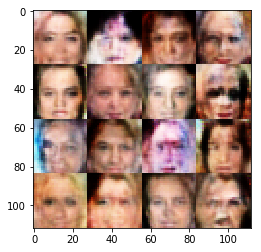

Epoch 1/1... Discriminator Loss: 1.4798... Generator Loss: 1.9476
Epoch 1/1... Discriminator Loss: 1.5107... Generator Loss: 2.4564
Epoch 1/1... Discriminator Loss: 1.5312... Generator Loss: 2.0282
Epoch 1/1... Discriminator Loss: 1.3630... Generator Loss: 2.3620
Epoch 1/1... Discriminator Loss: 1.2452... Generator Loss: 1.7947


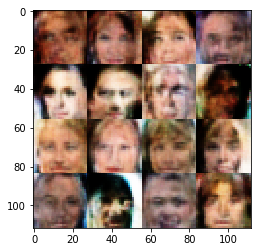

Epoch 1/1... Discriminator Loss: 0.4219... Generator Loss: 3.7063
Epoch 1/1... Discriminator Loss: 1.3692... Generator Loss: 1.8903
Epoch 1/1... Discriminator Loss: 0.4537... Generator Loss: 2.7491
Epoch 1/1... Discriminator Loss: 1.8525... Generator Loss: 3.5811
Epoch 1/1... Discriminator Loss: 0.8268... Generator Loss: 3.6434


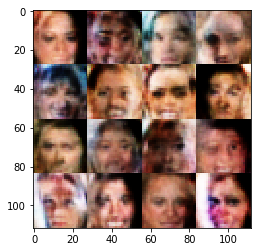

Epoch 1/1... Discriminator Loss: 1.5951... Generator Loss: 2.2325
Epoch 1/1... Discriminator Loss: 1.5405... Generator Loss: 2.5575
Epoch 1/1... Discriminator Loss: 1.2780... Generator Loss: 2.2709
Epoch 1/1... Discriminator Loss: 0.4949... Generator Loss: 3.1737
Epoch 1/1... Discriminator Loss: 1.7156... Generator Loss: 1.7359


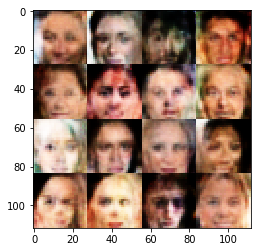

Epoch 1/1... Discriminator Loss: 1.4145... Generator Loss: 1.9187
Epoch 1/1... Discriminator Loss: 0.6562... Generator Loss: 3.5338
Epoch 1/1... Discriminator Loss: 0.9138... Generator Loss: 2.5882


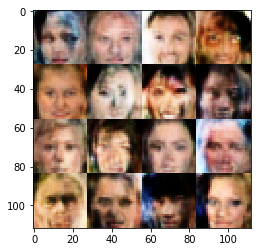

done.


IndexError: list index out of range

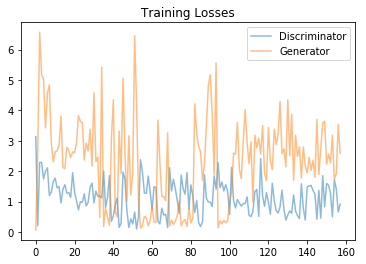

In [86]:

#Tuning of parameters from the attached paper
batch_size = 128
z_dim = 50
learning_rate = 0.0004
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.